(sec-modin)=
# Modin

Ray Data 提供的各类数据处理工具相对比较简单，只能做一些比较简单的转换，无法胜任复杂的数据处理任务。Modin 是一款专门加速 pandas 的框架。它对大数据进行了切分，使 DataFrame 分布到多核和集群上。早期，它底层使用了 Ray 作为分布式执行引擎，又被称为 Ray 上的 pandas（pandas on Ray）。之后又添加了 Dask 和 [unidist](https://github.com/modin-project/unidist/) 执行引擎，unidist 是 Modin 团队自己开发的分布式执行引擎。

在安装 Modin 时，要安装对应的执行引擎（Ray、Dask 或 unidist），比如 `pip install "modin[ray]"` 或 `pip install "modin[dask]"`。Modin 默认使用 Ray 作为其执行引擎。

## API 兼容性

Dask DataFrame 与 pandas DataFrame 其实有不少差异，很多 pandas 工作流并不能快速迁移到 Dask DataFrame 上。Modin 更看重与 pandas 的兼容性，用户只需要 `import modin.pandas as pd`，绝大多数 pandas 工作流可以快速迁移到 Modin 上。

Dask DataFrame 只按列对大数据进行切分，且没有记录每个 Partition 有多少数据，Modin 在多维度对数据进行切分，保留行标签和列标签。Modin 支持行索引 `iloc()`；记录了每个数据块的数据量，可以支持`median()`、`quantile()`；支持行和列的转换（比如，`pivot()`、`transpose()`）等操作。有关 Modin 的设计，可以参考其两篇论文 {cite}`petersohn2020Scalable` {cite}`petersohn2021Flexible`。

In [1]:
import os

import sys
sys.path.append("..")
from utils import nyc_flights

folder_path = nyc_flights()
file_path = os.path.join(folder_path, "*.csv")

ModuleNotFoundError: No module named 'utils'

:::{note}
Modin 的 API 尽量与 pandas 一致，比如，pandas 的 `read_csv()` 只能读一个文件，不能读 `*.csv` 这样的通配符。Modin 额外增加了一些 API，比如，Modin 拓展了 `read_csv()`，提出了 `read_csv_glob()` 方法 可以读取 `*.csv` 这样的通配符，适合读大数据。这些额外增加的 API 在 [`modin.experimental.pandas`](https://modin.readthedocs.io/en/stable/flow/modin/experimental/pandas.html) 中。
:::

In [ ]:
import modin.experimental.pandas as pd
df = pd.read_csv_glob(file_path, parse_dates={'Date': [0, 1, 2]})
df.iloc[3]

Date                 1991-01-11 00:00:00
DayOfWeek                              5
DepTime                           1303.0
CRSDepTime                          1215
ArrTime                           1439.0
CRSArrTime                          1336
UniqueCarrier                         US
FlightNum                            121
TailNum                              NaN
ActualElapsedTime                   96.0
CRSElapsedTime                        81
AirTime                              NaN
ArrDelay                            63.0
DepDelay                            48.0
Origin                               EWR
Dest                                 PIT
Distance                           319.0
TaxiIn                               NaN
TaxiOut                              NaN
Cancelled                              0
Diverted                               0
Name: 3, dtype: object

In [ ]:
df['ArrDelay'].median()

0.0

如果某些 API 在 Modin 中还没实现，Modin 会退回（Fallback）到 pandas，这也保证了兼容性。当然，缺点也很明显：将 Modin 的 DataFrame 转换为 pandas DataFrame 时，会有额外的开销；如果这个 DataFrame 分布在多个节点上，转化回 pandas 时会把数据集中到单机内存，有可能把单机内存挤爆。

## 立即执行

Modin 是立即执行，这一点与 pandas 一致。用户不需要像 Dask 那样调用 `.compute()` 来触发计算。

Modin 也没有 Dask DataFrame 的数据类型推断。{numref}`sec-dask-dataframe-read-write` 中的飞机起降数据上，Dask DataFrame `tail()` 会抛出异常，但 Modin 能够得到 pandas 一样的语义。

In [ ]:
df.tail(3)

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
1555982,1994-12-27,2,1721.0,1715,1930.0,1945,DL,149,NaN,129.0,...,NaN,-15.0,6.0,JFK,ATL,760.0,NaN,NaN,0,0
1555983,1994-12-28,3,1715.0,1715,1934.0,1945,DL,149,NaN,139.0,...,NaN,-11.0,0.0,JFK,ATL,760.0,NaN,NaN,0,0
1555984,1994-12-29,4,1715.0,1715,1941.0,1945,DL,149,NaN,146.0,...,NaN,-4.0,0.0,JFK,ATL,760.0,NaN,NaN,0,0


## 执行引擎

Modin 支持 Ray、Dask 和 unidist 分布式执行引擎：可以利用单机多核，也可以运行在集群上。以 Ray 为例，用户可以向 Ray 集群上提交作业，在代码中初始 Ray 运行时 `ray.init(address="auto")` 后，会将作业运行 Ray 集群。

Modin 默认使用 Ray 作为执行后端，也可以通过环境变量 `MODIN_ENGINE` 来设置执行后端，在命令行里：`export MODIN_ENGINE=dask`；或在 Jupyter Notebook 中：

```python
import modin.config as modin_cfg
modin_cfg.Engine.put("ray")
```

undist 是 Modin 自己实现的一个执行后端，它支持 MPI，如果想用 undist MPI，除了设置 `MODIN_ENGINE` 还要设置 `UNIDIST_BACKEND`：

```shell
export MODIN_ENGINE=unidist
export UNIDIST_BACKEND=mpi 
```

## 案例：纽约市出租车数据分析

我们将使用 Modin 对出租车数据进行数据分析。

In [1]:
import os

os.environ["MODIN_ENGINE"] = "dask"

import modin.config as modin_cfg
modin_cfg.Engine.put("dask")

import modin.experimental.pandas as pd
import matplotlib.pyplot as plt
from utils import nyc_taxi

taxi_path = nyc_taxi()

我们先读取数据。我们可以使用 `read_parquet_glob()` 与通配符 `*` 直接读取多个 Parquet 文件，在这里我们仅使用 `read_parquet()`。

In [2]:
df = pd.read_parquet(os.path.join(taxi_path, "yellow_tripdata_2023-01.parquet"))

df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00



下面我们展示数据预处理部分。

In [12]:
df = df.dropna(subset=['total_amount', 'RatecodeID'])

# 转换数据类型
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# 计算行程时长
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

接下来我们进行数据的条件筛选并使用 `groupby()` 切分数据。

In [13]:
# 选择含有非零乘客的行程
non_zero_passenger_df = df[df['passenger_count'] > 0]
average_trip_duration = non_zero_passenger_df['trip_duration'].mean()
print("平均行程时长（非零乘客）:")
print(average_trip_duration)

# 按支付方式分组，计算总费用的分布
total_amount_by_payment = non_zero_passenger_df.groupby('payment_type')['total_amount'].sum()
print("按支付方式分组的总费用:")
print(total_amount_by_payment)

# 对支付方式分组的数据进行排序
sorted_total_by_payment = total_amount_by_payment.sort_values(ascending=False)
print("\n按总费用降序排序的支付方式:")
print(sorted_total_by_payment)

# 按乘客数量分组，计算平均行程距离和总费用
avg_distance_amount_by_passenger = df.groupby('passenger_count').agg({
    'trip_distance': 'mean',
    'total_amount': 'mean'
})
print("\n按乘客数量分组的平均行程距离和总费用:")
print(avg_distance_amount_by_passenger)

平均行程时长（非零乘客）:
15.68557239550762
按支付方式分组的总费用:
payment_type
1    67232359.58
2    12062049.01
3      165402.32
4       79019.28
Name: total_amount, dtype: float64

按总费用降序排序的支付方式:
payment_type
1    67232359.58
2    12062049.01
3      165402.32
4       79019.28
Name: total_amount, dtype: float64

按乘客数量分组的平均行程距离和总费用:
                 trip_distance  total_amount
passenger_count                             
0.0                   2.761904     24.162124
1.0                   3.338169     26.443472
2.0                   3.931051     29.313282
3.0                   3.664393     28.475420
4.0                   3.812581     29.611602
5.0                   3.282478     26.588261
6.0                   3.250963     26.558484
7.0                   4.238333     85.111667
8.0                   4.270769     99.336923
9.0                   0.000000     92.250000


我们再使用 `apply()` 对数据进行操作，以及使用 `pivot_table()` 创建数据透视表。

In [14]:
# 应用函数计算含税车费
df['fare_with_tax'] = df.apply(lambda row: row['fare_amount'] + row['mta_tax'], axis=1)
print("计算含税车费:")
print(df[['fare_amount', 'mta_tax', 'fare_with_tax']].head())

# 重塑数据创建数据透视表
pivot_table = df.pivot_table(values='total_amount', index='DOLocationID', columns='payment_type', aggfunc='mean')
print("\n数据透视表（总费用按下车地点和支付方式）:")
print(pivot_table.head())

计算含税车费:
   fare_amount  mta_tax  fare_with_tax
0          9.3      0.5            9.8
1          7.9      0.5            8.4
2         14.9      0.5           15.4
3         12.1      0.5           12.6
4         11.4      0.5           11.9

数据透视表（总费用按下车地点和支付方式）:
payment_type           1           2          3          4
DOLocationID                                              
1             130.041868  108.956124  73.196774   1.598767
2              58.446250   31.411538        NaN   0.000000
3              62.407438   65.358209   1.500000  12.360000
4              27.395179   20.115848  12.228704   2.635455
5             103.328113  135.500000        NaN        NaN


最后我们展示可视化部分。

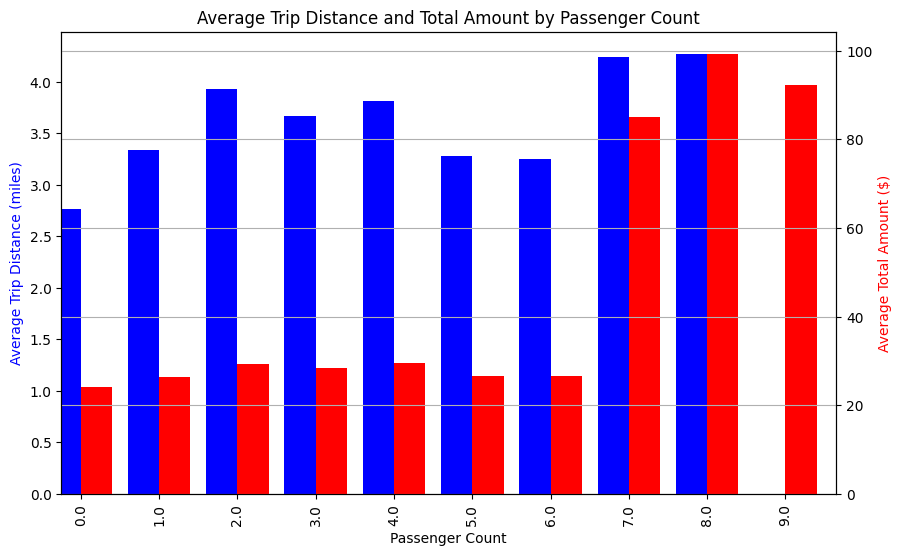

In [15]:
# 绘制乘客数量分组的平均行程距离和总费用柱状图
fig, ax1 = plt.subplots(figsize=(10, 6))
avg_distance_amount_by_passenger['trip_distance'].plot(kind='bar', color='blue', ax=ax1, position=1, width=0.4)
ax1.set_ylabel('Average Trip Distance (miles)', color='blue')
ax2 = ax1.twinx()
avg_distance_amount_by_passenger['total_amount'].plot(kind='bar', color='red', ax=ax2, position=0, width=0.4)
ax2.set_ylabel('Average Total Amount ($)', color='red')
plt.title('Average Trip Distance and Total Amount by Passenger Count')
ax1.set_xlabel('Passenger Count')
plt.grid(True)
plt.show()